## Import Necessary Packages

In [29]:
import os
import torch
import warnings
import numpy as np
import xarray as xr
import pandas as pd
import proplot as pplt
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset,DataLoader
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score,mean_squared_log_error
pplt.rc['figure.dpi'] = 100
warnings.filterwarnings('ignore')

## Functions

In [2]:
def load(varname):
    data = xr.open_dataset('/global/cfs/cdirs/m4334/sferrett/monsoon-pod/data/processed/LR_ERA5_IMERG_pr_bl_terms.nc')
    return data[varname].load()

def log_normalize(data,c=1.0):
    '''Logarithmic normalization: X' = ln(X+c), where X is the precipitation data, and c is a constant to handle 0 values'''
    normdata = np.log(data+c)
    return normdata

def inverse_log_normalize(normdata,c=1.0):
    data = np.exp(normdata)-c
    return data

def prepare(inputs,target,testsize):
    inputs   = [inputs] if not isinstance(inputs,list) else inputs
    combined = xr.merge([*inputs,target])
    df = combined.to_dataframe().reset_index()
    df = df.sort_values('time')
    x  = df[[i.name for i in inputs]]
    y  = df[[target.name]]
    xtrain,xtest,ytrain,ytest = train_test_split(x,y,test_size=testsize,shuffle=False)
    return xtrain,xtest,ytrain,ytest

## Load Data

In [3]:
bl  = load('bl')
pr  = load('pr')
prlog = log_normalize(pr,c=1.0)

## Exploratory Plots

In [4]:
x    = bl.values.flatten()
y    = pr.values.flatten()
ylog = prlog.values.flatten()
bins = 100

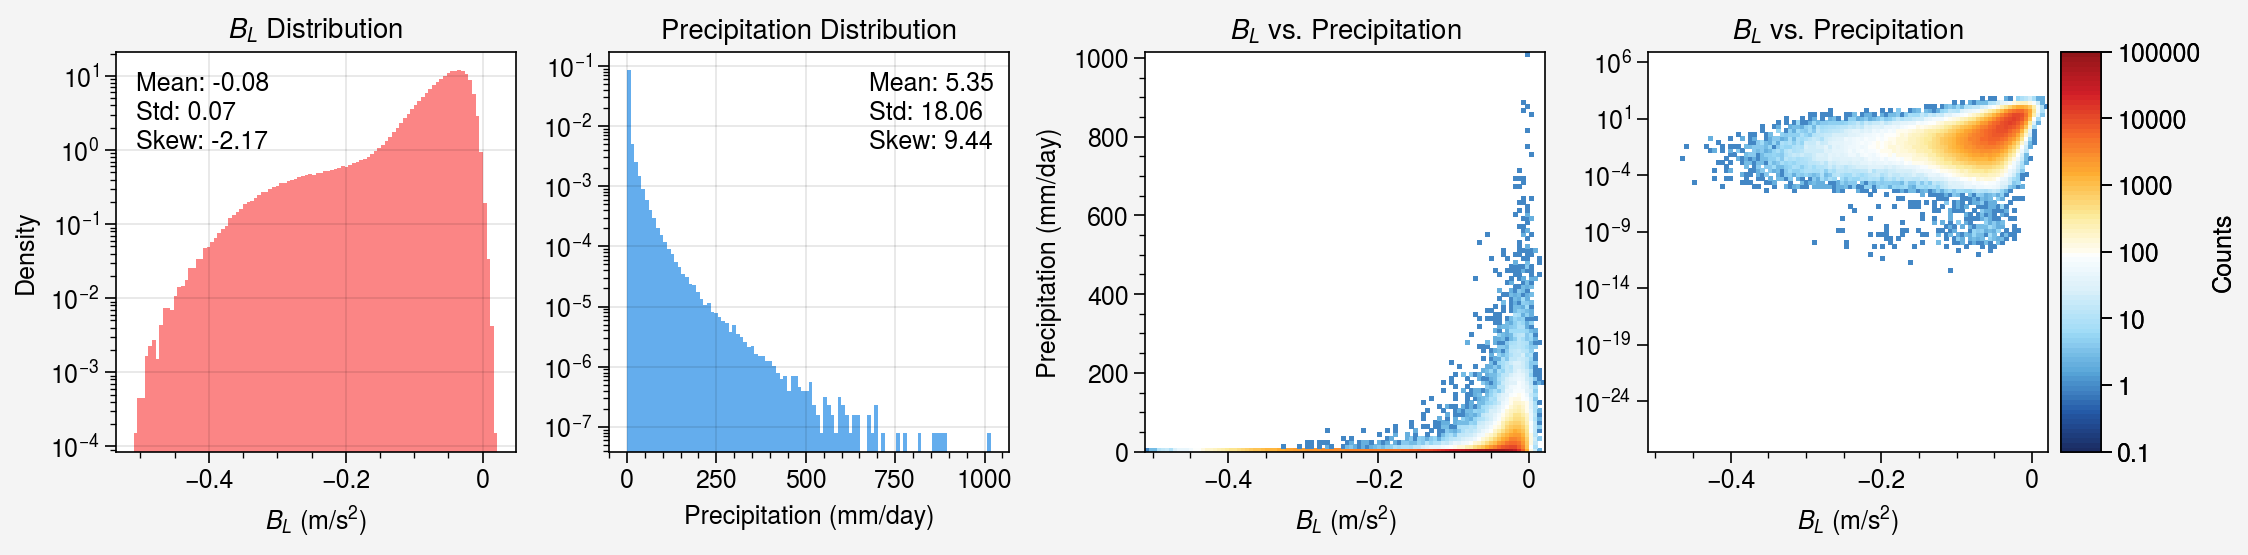

In [5]:
fig,axs = pplt.subplots(nrows=1,ncols=4,refwidth=2,share=False)
axs[0].format(title='$\mathit{B_L}$ Distribution',xlabel='$\mathit{B_L}$ (m/s$^2$)',ylabel='Density',yscale='log',yformatter='log')
axs[1].format(title='Precipitation Distribution',xlabel='Precipitation (mm/day)',yscale='log',yformatter='log')
axs[2].format(title='$\mathit{B_L}$ vs. Precipitation',xlabel='$\mathit{B_L}$ (m/s$^2$)',ylabel='Precipitation (mm/day)')
axs[3].format(title='$\mathit{B_L}$ vs. Precipitation',xlabel='$\mathit{B_L}$ (m/s$^2$)',yscale='log',yformatter='log')

axs[0].hist(x,bins=bins,density=True,color='red6',alpha=0.7)
axs[1].hist(y,bins=bins,density=True,color='blue6',alpha=0.7)
statsx = f'Mean: {np.mean(x):.2f}\nStd: {np.std(x):.2f}\nSkew: {stats.skew(x):.2f}'
statsy = f'Mean: {np.mean(y):.2f}\nStd: {np.std(y):.2f}\nSkew: {stats.skew(y):.2f}'
axs[0].text(0.05,0.95,statsx,transform=axs[0].transAxes,va='top')
axs[1].text(0.65,0.95,statsy,transform=axs[1].transAxes,va='top')

hist,xedges,yedges = np.histogram2d(x,y,bins=(bins,bins))
hist = np.ma.masked_where(hist==0,hist)
mesh = axs[2].pcolormesh(xedges,yedges,hist.T,cmap='ColdHot',norm='log',levels=100)

xedges = np.linspace(np.min(x),np.max(x),bins+1)
yedges = np.logspace(np.log(np.min(y[y>0])),np.log(np.max(y)),bins+1)
hist,_,_ = np.histogram2d(x,y,bins=(xedges,yedges))
hist = np.ma.masked_where(hist==0,hist)
meshlog = axs[3].pcolormesh(xedges,yedges,hist.T,cmap='ColdHot',norm='log',levels=100)

axs[3].colorbar(meshlog,label='Counts',ticks=[0.1,1,10,100,1000,10000,100000])

pplt.show()

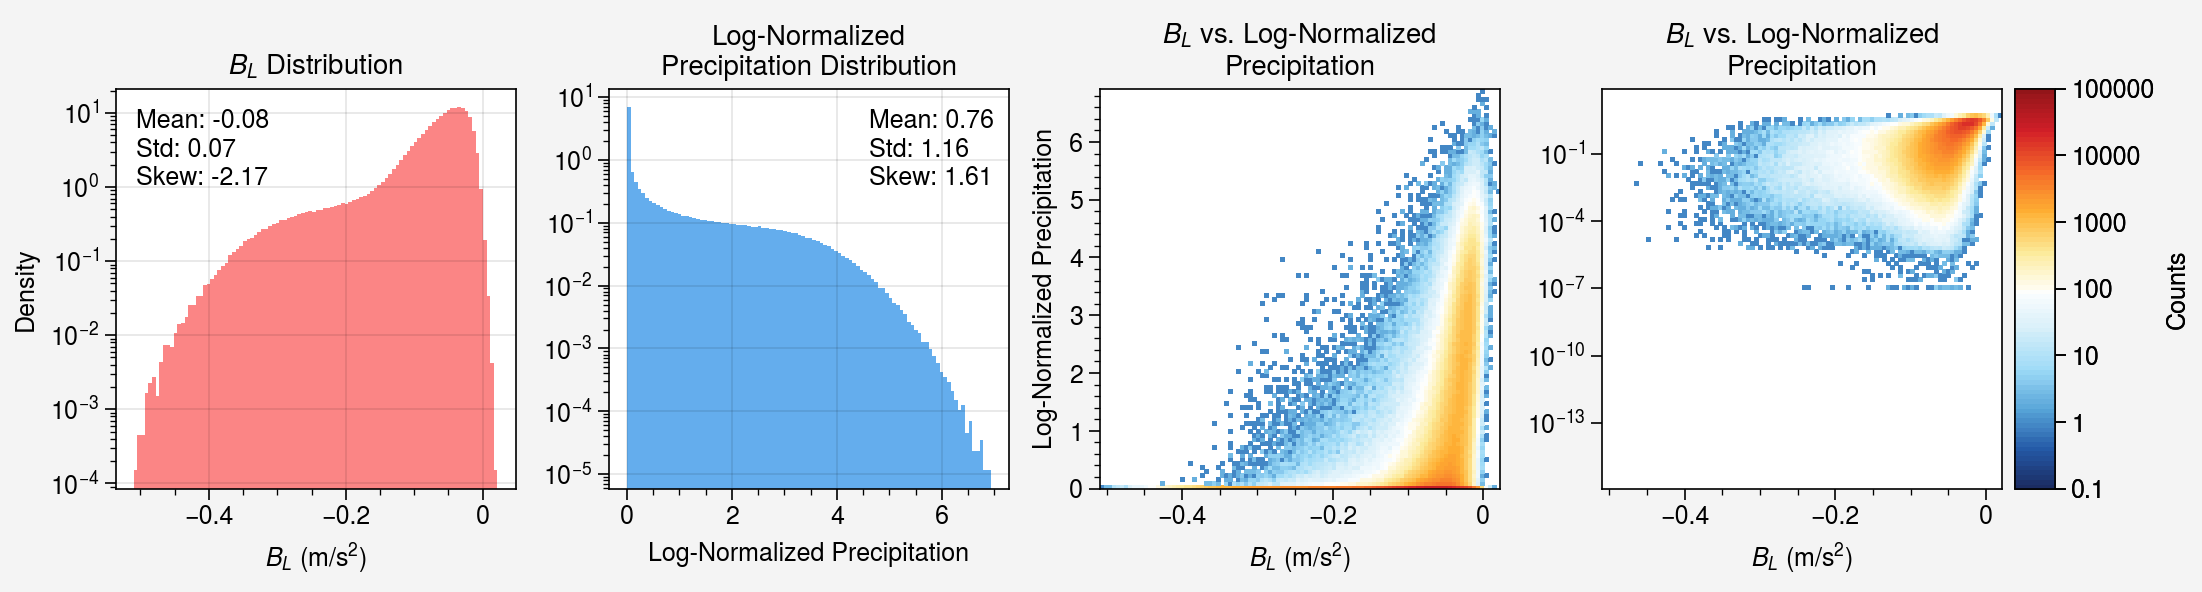

In [6]:
fig,axs = pplt.subplots(nrows=1,ncols=4,refwidth=2,share=False)
axs[0].format(title='$\mathit{B_L}$ Distribution',xlabel='$\mathit{B_L}$ (m/s$^2$)',ylabel='Density',yscale='log',yformatter='log')
axs[1].format(title='Log-Normalized\nPrecipitation Distribution',xlabel='Log-Normalized Precipitation',yscale='log',yformatter='log')
axs[2].format(title='$\mathit{B_L}$ vs. Log-Normalized\nPrecipitation',xlabel='$\mathit{B_L}$ (m/s$^2$)',ylabel='Log-Normalized Precipitation')
axs[3].format(title='$\mathit{B_L}$ vs. Log-Normalized\nPrecipitation',xlabel='$\mathit{B_L}$ (m/s$^2$)',yscale='log',yformatter='log')

axs[0].hist(x,bins=bins,density=True,color='red6',alpha=0.7)
axs[1].hist(ylog,bins=bins,density=True,color='blue6',alpha=0.7)
statsx = f'Mean: {np.mean(x):.2f}\nStd: {np.std(x):.2f}\nSkew: {stats.skew(x):.2f}'
statsy = f'Mean: {np.mean(ylog):.2f}\nStd: {np.std(ylog):.2f}\nSkew: {stats.skew(ylog):.2f}'
axs[0].text(0.05,0.95,statsx,transform=axs[0].transAxes,va='top')
axs[1].text(0.65,0.95,statsy,transform=axs[1].transAxes,va='top')

hist,xedges,yedges = np.histogram2d(x,ylog,bins=(bins,bins))
hist = np.ma.masked_where(hist==0,hist)
mesh = axs[2].pcolormesh(xedges,yedges,hist.T,cmap='ColdHot',norm='log',levels=100)

xedges = np.linspace(np.min(x),np.max(x),bins+1)
yedges = np.logspace(np.log(np.min(ylog[ylog>0])),np.log(np.max(ylog)),bins+1)
hist,_,_ = np.histogram2d(x,ylog,bins=(xedges,yedges))
hist = np.ma.masked_where(hist==0,hist)
meshlog = axs[3].pcolormesh(xedges,yedges,hist.T,cmap='ColdHot',norm='log',levels=100)

axs[3].colorbar(meshlog,label='Counts',ticks=[0.1,1,10,100,1000,10000,100000])

pplt.show()

## Split Data

In [7]:
xtrain,xtest,ytrain,ytest = prepare(inputs=[bl],target=pr,testsize=0.2)

ytrainlog = ytrain.apply(lambda v:log_normalize(v,c=1.0))
ytestlog  = ytest.apply(lambda v:log_normalize(v,c=1.0))

## Analytical Baselines

### Model Class

In [23]:
class BASELINE:
    
    def __init__(self,binwidth,binmin,binmax,samplethresh):
        self.binwidth      = binwidth
        self.binmin        = binmin
        self.binmax        = binmax
        self.binedges      = np.arange(self.binmin,self.binmax+self.binwidth,self.binwidth)
        self.bincenters    = (self.binedges[:-1]+self.binedges[1:])/2
        self.nbins         = len(self.bincenters)
        self.samplethresh  = samplethresh
        self.model         = None

    def fit(self,inputs,targets):
        idxs  = np.digitize(inputs,self.binedges)-1
        Q0,Q1 = np.zeros(self.nbins),np.zeros(self.nbins)
        for i in range(targets.size):
            idx    = idxs[i]
            target = targets[i]
            if 0<=idx<self.nbins and np.isfinite(target):
                Q0[idx] += 1
                Q1[idx] += target
        with np.errstate(divide='ignore',invalid='ignore'):
            self.model = np.where(Q0>=self.samplethresh,Q1/Q0,np.nan)
        return (self.bincenters,self.model)

    def predict(self,inputs):
        binidxs = np.clip(np.digitize(inputs,self.binedges)-1,0,self.nbins-1)
        outputs = self.model[binidxs]
        outputs = np.maximum(outputs,0) # Enforce non-negative constraint
        return outputs
    
    # def evaluate(self,outputs,targets):
    #     mask    = ~np.isnan(outputs)&~np.isnan(targets)
    #     outputs = torch.FloatTensor(outputs[mask])
    #     targets = torch.FloatTensor(targets[mask])
    #     loss    = self.criterion(outputs,targets).item()
    #     return loss

### Train Baselines

In [30]:
configs = [
    {'binwidth':0.1,
     'description':'Binwidth = 0.1'},
    {'binwidth':0.01,  
     'description':'Binwidth = 0.01'},
    {'binwidth':0.001,   
     'description':'Binwidth = 0.001'}]

baselineresults = {}
for config in configs:
    print(f'Training {config["description"]}')
    baseline = BASELINE(
        binwidth=config['binwidth'],
        binmin=-0.6,
        binmax=0.1,
        samplethresh=50)
    baselinemodel   = baseline.fit(xtrain['bl'].values,ytrain['pr'].values)
    baselineoutputs = baseline.predict(xtest['bl'].values)
    baselineresults[f'binwidth_{config["binwidth"]}'] = {
        'description':config['description'],
        'binwidth':config['binwidth'],
        'bincenters':baseline.bincenters, 
        'binmeans':baseline.model, 
        'testoutputs':baselineoutputs}

Training Binwidth = 0.1
Training Binwidth = 0.01
Training Binwidth = 0.001


## MLPs

### Model Class

In [10]:
class MLPMODEL(torch.nn.Module):
    
    def __init__(self,inputsize,hiddensize,outputsize,nhiddenlayers,activation=None):
        super(MLPMODEL,self).__init__()    
        self.inputsize     = inputsize
        self.hiddensize    = hiddensize
        self.outputsize    = outputsize
        self.nhiddenlayers = nhiddenlayers
        self.activation    = activation if activation is not None else torch.nn.Identity()
        layers = []
        layers.append(torch.nn.Linear(inputsize,hiddensize))
        layers.append(self.activation)
        for _ in range(nhiddenlayers-1):
            layers.append(torch.nn.Linear(hiddensize,hiddensize))
            layers.append(self.activation)
        layers.append(torch.nn.Linear(hiddensize,outputsize))
        self.layers = torch.nn.Sequential(*layers)
    def forward(self,x):
        return self.layers(x)

class MLP:
    
    def __init__(self,inputsize,hiddensize,outputsize,nhiddenlayers,activation,criterion,learningrate,nepochs,batchsize,validsplit,patience,randomstate,logtransform=False):
        self.model        = MLPMODEL(inputsize,hiddensize,outputsize,nhiddenlayers,activation)
        self.criterion    = criterion
        self.optimizer    = torch.optim.Adam(self.model.parameters(),lr=learningrate)
        self.nepochs      = nepochs
        self.batchsize    = batchsize
        self.validsplit   = validsplit
        self.patience     = patience
        self.randomstate  = randomstate
        self.logtransform = logtransform
        self.device       = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model.to(self.device)

    def _tensor(self,data):
        if isinstance(data,pd.DataFrame):
            return torch.FloatTensor(data.values)
        elif isinstance(data,pd.Series):
            return torch.FloatTensor(data.values.reshape(-1,1))
        elif isinstance(data,np.ndarray):
            if data.ndim==1:
                return torch.FloatTensor(data.reshape(-1,1))
            return data
        elif isinstance(data,list):
            return torch.FloatTensor(np.array(data).reshape(-1,1))
        else:
            raise ValueError('Unsupported data type. Please provide a pd.DataFrame, pd.Series, np.ndarray, or list.')   

    def fit(self,inputs,targets):
        inputs  = self._tensor(inputs)
        targets = self._tensor(targets)
        xtrain,xvalid,ytrain,yvalid = train_test_split(inputs,targets,test_size=self.validsplit,random_state=self.randomstate)
        traindataset = TensorDataset(xtrain,ytrain)
        validdataset = TensorDataset(xvalid,yvalid)
        trainloader  = DataLoader(traindataset,batch_size=self.batchsize,shuffle=True)
        validloader  = DataLoader(validdataset,batch_size=self.batchsize,shuffle=False)
        trainlosses = []
        validlosses = []
        
        # Add these for back-transformed losses
        if self.logtransform:
            trainlossesbt = []
            validlossesbt = []
            
        bestvalidloss   = float('inf')
        patiencecounter = 0
        for epoch in range(self.nepochs):
            self.model.train()
            trainloss   = 0.0
            
            # Back-transformed
            trainlossbt = 0.0
            
            for batchinputs,batchtargets in trainloader:
                self.optimizer.zero_grad()
                batchoutputs = self.model(batchinputs)
                batchloss    = self.criterion(batchoutputs,batchtargets)
                batchloss.backward()
                self.optimizer.step()
                trainloss += batchloss.item()*batchinputs.size(0)

                # Calculate back-transformed loss using specified criterion
                if self.logtransform:
                    outputsbt = torch.exp(batchoutputs)-1
                    targetsbt = torch.exp(batchtargets)-1
                    batchlossbt = self.criterion(outputsbt,targetsbt)
                    trainlossbt += batchlossbt.item()*batchinputs.size(0)
                    
            trainloss /= len(trainloader.dataset)
            trainlosses.append(trainloss) 

            if self.logtransform:
                trainlossbt /= len(trainloader.dataset)
                trainlossesbt.append(trainlossbt)

            self.model.eval()
            validloss   = 0.0

            # Back-transformed
            validlossbt = 0.0
            
            with torch.no_grad():
                for batchinputs,batchtargets in validloader:
                    batchoutputs = self.model(batchinputs)
                    batchloss    = self.criterion(batchoutputs,batchtargets)
                    validloss   += batchloss.item()*batchinputs.size(0)
            
                    # Calculate back-transformed loss using specified criterion
                    if self.logtransform:
                        outputsbt = torch.exp(batchoutputs)-1
                        targetsbt = torch.exp(batchtargets)-1
                        batchlossbt = self.criterion(outputsbt,targetsbt)
                        validlossbt += batchlossbt.item()*batchinputs.size(0)            
            
            validloss /= len(validloader.dataset)
            validlosses.append(validloss)

            if self.logtransform:
                validlossbt /= len(validloader.dataset)
                validlossesbt.append(validlossbt)

            if self.logtransform:
                print(f'Epoch {epoch+1}/{self.nepochs} - Training Loss: {trainloss:.4f} (log),{trainlossbt:.4f} - Validation Loss: {validloss:.4f} (log), {validlossbt:.4f}')
            else:
                print(f'Epoch {epoch+1}/{self.nepochs} - Training Loss: {trainloss:.4f}, Validation Loss: {validloss:.4f}')

            if validloss<bestvalidloss:
                bestvalidloss   = validloss
                patiencecounter = 0
                torch.save(self.model.state_dict(),'best_model.pth')
            else:
                patiencecounter += 1
                if patiencecounter>=self.patience:
                    print(f'Early stopping triggered after {epoch+1} epochs!')
                    self.model.load_state_dict(torch.load('best_model.pth'))
                    break

        if self.logtransform:
            return (trainlosses,validlosses,trainlossesbt,validlossesbt)
        else:
            return (trainlosses,validlosses)

    def predict(self,inputs):
        inputs  = self._tensor(inputs).to(self.device)
        self.model.eval()
        with torch.no_grad():
            outputs = self.model(inputs)
        return outputs.cpu().numpy()

    def evaluate(self,inputs,targets):
        inputs  = self._tensor(inputs).to(self.device)
        targets = self._tensor(targets).to(self.device)
        self.model.eval()
        with torch.no_grad():
            outputs = self.model(inputs)
            loss    = self.criterion(outputs,targets).item()
        return loss

### Train Regular MLPs

In [11]:
configs = [
    {'name':'linear_mse',
     'activation':torch.nn.Identity(),
     'criterion':torch.nn.MSELoss(),
     'description':'Linear MSE'},
    {'name':'linear_mae',
     'activation':torch.nn.Identity(), 
     'criterion':torch.nn.L1Loss(),    
     'description':'Linear MAE'},
    {'name':'relu_mse',
     'activation':torch.nn.ReLU(),
     'criterion':torch.nn.MSELoss(),
     'description':'Nonlinear MSE'},
    {'name':'relu_mae',
     'activation':torch.nn.ReLU(),
     'criterion':torch.nn.L1Loss(),
     'description':'Nonlinear MAE'}]

trainedmodels = {}
results       = {}
for config in configs:
    print(f"Training {config['description']}")
    print(f"{'='*60}")
    mlp = MLP(
        inputsize=xtrain.shape[1], 
        hiddensize=64, 
        outputsize=ytrain.shape[1], 
        nhiddenlayers=1,
        activation=config['activation'],
        criterion=config['criterion'],
        learningrate=0.001,
        nepochs=50,
        batchsize=500,
        validsplit=0.25,
        patience=2,
        randomstate=42,
        logtransform=False)
    trainlosses,validlosses = mlp.fit(xtrain['bl'].values,ytrain['pr'].values)
    modelfilename = f'best_model_{config["name"]}.pth'
    torch.save(mlp.model.state_dict(),modelfilename)
    print(f"Model saved as: {modelfilename}")
    testoutputs = mlp.predict(xtest['bl'].values)
    testloss    = mlp.evaluate(xtest['bl'].values,ytest['pr'].values)
    trainedmodels[config['name']] = mlp
    results[config['name']] = {
        'trainlosses':trainlosses,
        'validlosses':validlosses,
        'testoutputs':testoutputs,
        'testloss':testloss,
        'modelfile':modelfilename,
        'description':config['description']}

Training Linear MSE
Epoch 1/50 - Training Loss: 326.6972, Validation Loss: 317.7857
Epoch 2/50 - Training Loss: 318.4142, Validation Loss: 317.6598
Epoch 3/50 - Training Loss: 318.4023, Validation Loss: 317.6210
Epoch 4/50 - Training Loss: 318.4000, Validation Loss: 317.6824
Epoch 5/50 - Training Loss: 318.3996, Validation Loss: 317.6517
Early stopping triggered after 5 epochs!
Model saved as: best_model_linear_mse.pth
Training Linear MAE
Epoch 1/50 - Training Loss: 5.3441, Validation Loss: 5.3260
Epoch 2/50 - Training Loss: 5.3429, Validation Loss: 5.3250
Epoch 3/50 - Training Loss: 5.3429, Validation Loss: 5.3250
Epoch 4/50 - Training Loss: 5.3428, Validation Loss: 5.3249
Epoch 5/50 - Training Loss: 5.3428, Validation Loss: 5.3251
Epoch 6/50 - Training Loss: 5.3428, Validation Loss: 5.3250
Early stopping triggered after 6 epochs!
Model saved as: best_model_linear_mae.pth
Training Nonlinear MSE
Epoch 1/50 - Training Loss: 329.9584, Validation Loss: 318.5392
Epoch 2/50 - Training Loss:

### Train Log-Normalized MLPs

In [12]:
configslog = [
    {'name':'linear_mse_log',
     'activation':torch.nn.Identity(),
     'criterion':torch.nn.MSELoss(),
     'description':'Log-Norm Linear MSE'},
    {'name':'linear_mae_log',
     'activation':torch.nn.Identity(), 
     'criterion':torch.nn.L1Loss(),    
     'description':'Log-Norm Linear MAE'},
    {'name':'relu_mse_log',
     'activation':torch.nn.ReLU(),
     'criterion':torch.nn.MSELoss(),
     'description':'Log-Norm Nonlinear MSE'},
    {'name':'relu_mae_log',
     'activation':torch.nn.ReLU(),
     'criterion':torch.nn.L1Loss(),
     'description':'Log-Norm Nonlinear MAE'}]

trainedmodelslog = {}
resultslog       = {}
for config in configslog:
    print(f"Training {config['description']}")
    print(f"{'='*60}")
    mlp = MLP(
        inputsize=xtrain.shape[1], 
        hiddensize=64, 
        outputsize=ytrainlog.shape[1], 
        nhiddenlayers=1,
        activation=config['activation'],
        criterion=config['criterion'],
        learningrate=0.001,
        nepochs=50,
        batchsize=500,
        validsplit=0.25,
        patience=2,
        randomstate=42,
        logtransform=True)
    trainlosses,validlosses,trainlossesbt,validlossesbt = mlp.fit(xtrain['bl'].values,ytrainlog['pr'].values)
    modelfilename = f'best_model_{config["name"]}.pth'
    torch.save(mlp.model.state_dict(),modelfilename)
    print(f"Model saved as: {modelfilename}")
    testoutputs = mlp.predict(xtest['bl'].values)
    testloss    = mlp.evaluate(xtest['bl'].values,ytestlog['pr'].values)
    trainedmodelslog[config['name']] = mlp
    resultslog[config['name']] = {
        'trainlosses':trainlossesbt,
        'validlosses':validlossesbt,
        'trainlosseslog':trainlosses,
        'validlosseslog':validlosses,
        'testoutputs':testoutputs,
        'testloss':testloss,
        'modelfile':modelfilename,
        'description':config['description']}

Training Log-Norm Linear MSE
Epoch 1/50 - Training Loss: 1.1540 (log),345.7878 - Validation Loss: 1.1237 (log), 342.2861
Epoch 2/50 - Training Loss: 1.1241 (log),344.0138 - Validation Loss: 1.1227 (log), 343.2099
Epoch 3/50 - Training Loss: 1.1244 (log),344.0168 - Validation Loss: 1.1229 (log), 343.1799
Epoch 4/50 - Training Loss: 1.1241 (log),344.0021 - Validation Loss: 1.1227 (log), 342.8928
Epoch 5/50 - Training Loss: 1.1242 (log),343.9966 - Validation Loss: 1.1230 (log), 343.4908
Epoch 6/50 - Training Loss: 1.1243 (log),344.0037 - Validation Loss: 1.1228 (log), 343.2697
Early stopping triggered after 6 epochs!
Model saved as: best_model_linear_mse_log.pth
Training Log-Norm Linear MAE
Epoch 1/50 - Training Loss: 0.7278 (log),5.3389 - Validation Loss: 0.7278 (log), 5.3222
Epoch 2/50 - Training Loss: 0.7273 (log),5.3380 - Validation Loss: 0.7257 (log), 5.3202
Epoch 3/50 - Training Loss: 0.7273 (log),5.3380 - Validation Loss: 0.7257 (log), 5.3200
Epoch 4/50 - Training Loss: 0.7273 (log

### Training/Validation Plot

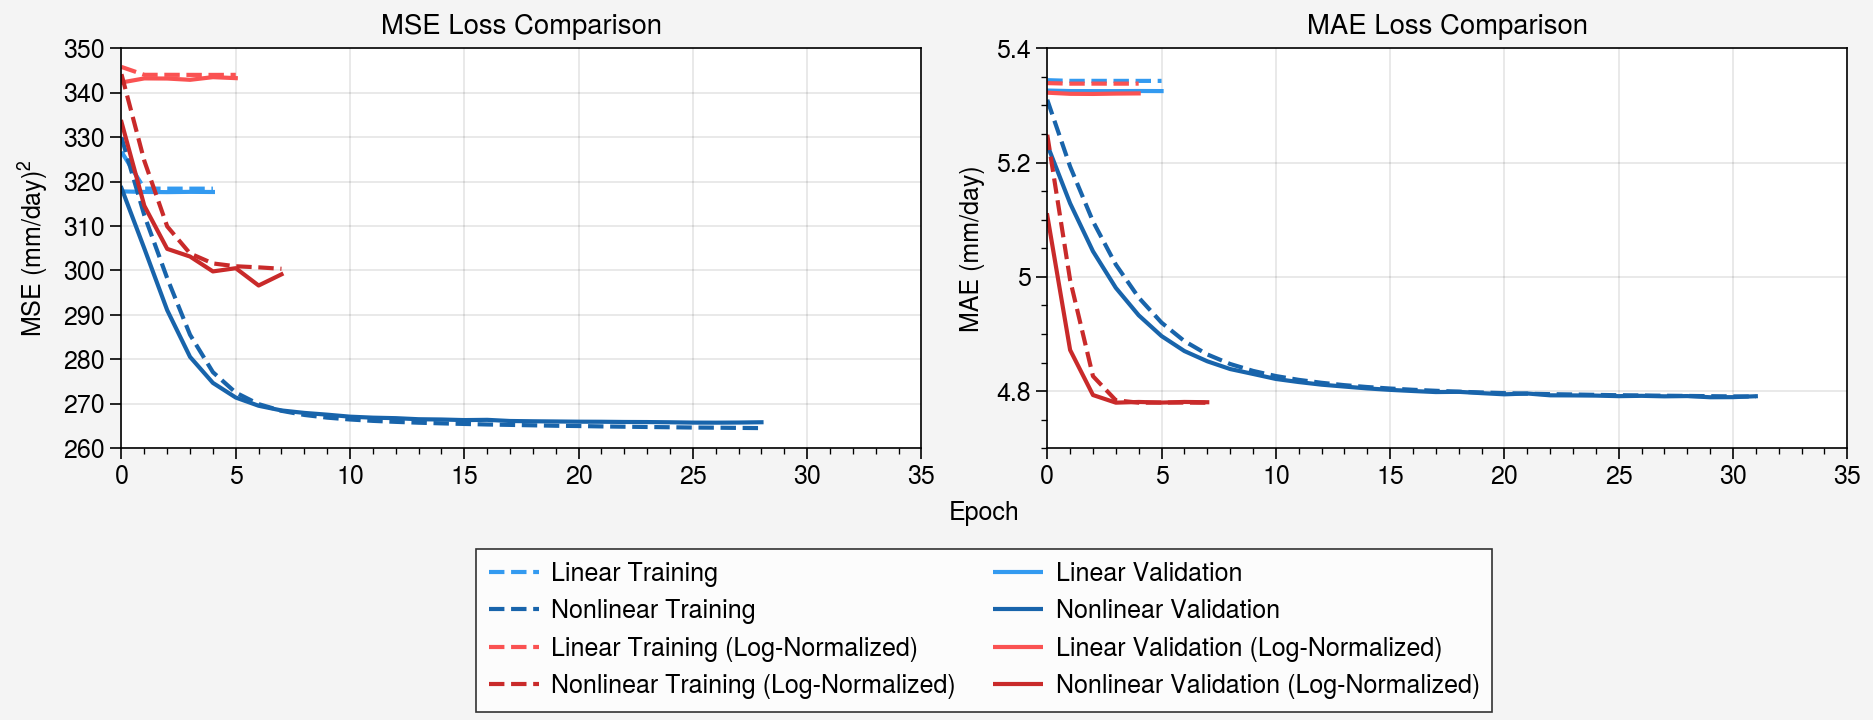

In [28]:
fig,axs = pplt.subplots(nrows=1,ncols=2,refwidth=4,refheight=2,sharex=True,sharey=False)
axs.format(xlabel='Epoch',xlim=(0,35))
axs[0].format(title='MSE Loss Comparison',ylabel='MSE (mm/day)$^2$',ylim=(260,350),yticks=10,yminorticks='none')
axs[1].format(title='MAE Loss Comparison',ylabel='MAE (mm/day)',ylim=(4.7,5.4))
colors = ['blue5','blue9','red6','red9']
for i,(ax,loss) in enumerate(zip(axs,['mse','mae'])):
    ax.plot(results[f'linear_{loss}']['trainlosses'],color=colors[0],linestyle='--',label='Linear Training' if i==0 else None)
    ax.plot(results[f'linear_{loss}']['validlosses'],color=colors[0],linestyle='-',label='Linear Validation' if i==0 else None)
    ax.plot(results[f'relu_{loss}']['trainlosses'],color=colors[1],linestyle='--',label='Nonlinear Training' if i==0 else None)
    ax.plot(results[f'relu_{loss}']['validlosses'],color=colors[1],linestyle='-',label='Nonlinear Validation' if i==0 else None)
    ax.plot(resultslog[f'linear_{loss}_log']['trainlosses'],color=colors[2],linestyle='--',label='Linear Training (Log-Normalized)' if i==0 else None)
    ax.plot(resultslog[f'linear_{loss}_log']['validlosses'],color=colors[2],linestyle='-',label='Linear Validation (Log-Normalized)' if i==0 else None)
    ax.plot(resultslog[f'relu_{loss}_log']['trainlosses'],color=colors[3],linestyle='--',label='Nonlinear Training (Log-Normalized)' if i==0 else None)
    ax.plot(resultslog[f'relu_{loss}_log']['validlosses'],color=colors[3],linestyle='-',label='Nonlinear Validation (Log-Normalized)' if i==0 else None)
fig.legend(loc='b',ncols=2)
pplt.show()

## Metrics

In [33]:
def calc_metrics(ytrue,ypred):
    mask = ~np.isnan(ytrue)&~np.isnan(ypred)
    ytrueclean = ytrue[mask]
    ypredclean = ypred[mask]
    metrics = {}
    metrics['MSE']  = mean_squared_error(ytrueclean,ypredclean)
    metrics['RMSE'] = np.sqrt(metrics['MSE'])
    metrics['MAE']  = mean_absolute_error(ytrueclean,ypredclean)
    metrics['R2']   = r2_score(ytrueclean,ypredclean)
    return metrics

In [ ]:
allmetrics = {}
for modeldict in [results,resultslog,baselineresults]:
    for modelname,result in modeldict.items():
        ytrue = ytest['pr'].values
        if modeldict==results or modeldict==baselineresults:
            ypred = result['testoutputs']
        elif modeldict==resultslog:
            ypred = inverse_log_normalize(result['testoutputs'],c=1.0)
        metrics = calc_metrics(ytrue,ypred)
        metrics['Title'] = result['description']
        allmetrics[modelname] = metrics
        
metricsdf = pd.DataFrame.from_dict(allmetrics,orient='index')
metricsdf

Plot Types

- Barplot of Metric: ranks all models by chosen metric, find best model by metric
- Violin/Boxplot Error: distribution of prediction errors, check residuals and bias
- Scatter Plot (Pred vs True): fit quality and bias, see if model output is calibrated
- Heatmap/Table: full overview of all metrics, quick overall comparison
- Line Plot Multi-metric: trends for several metrics, per model	multi-metric optimization

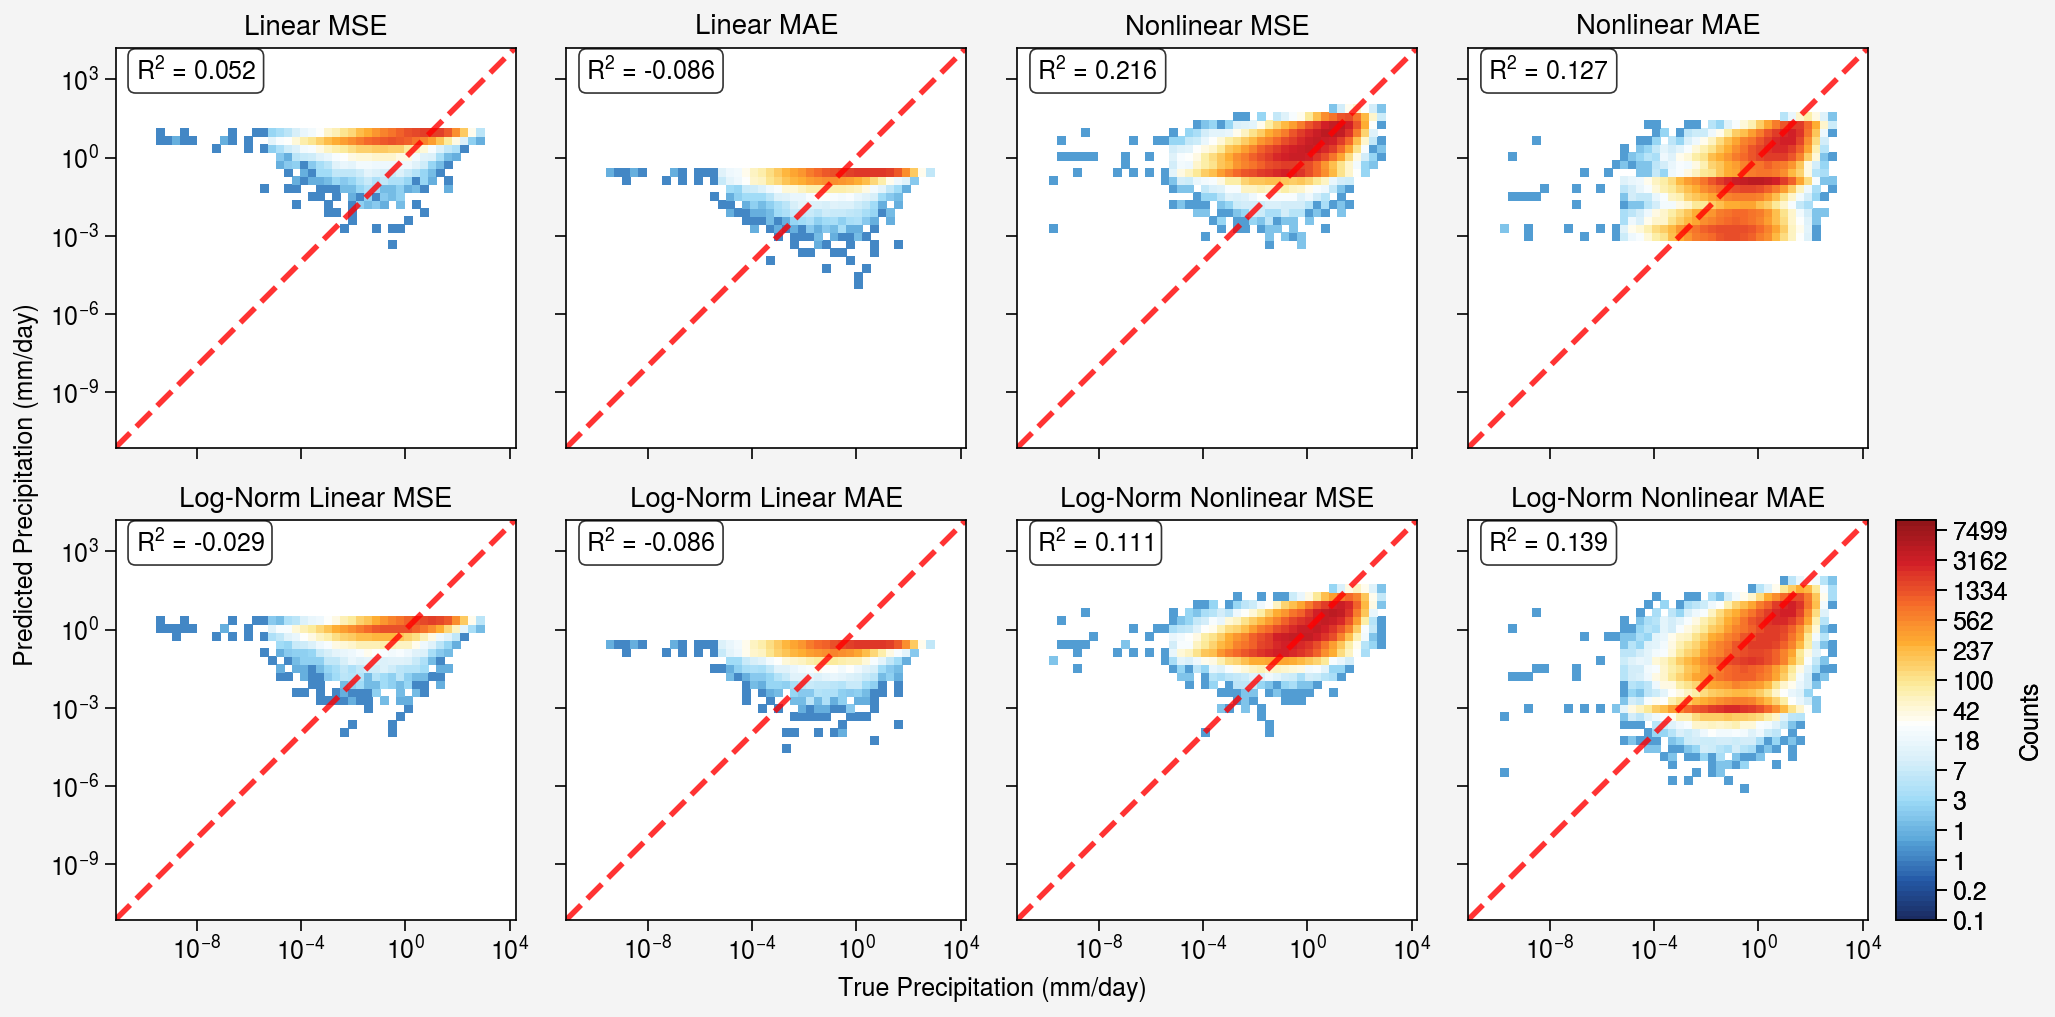

In [19]:
# First, determine global axis limits for consistent scaling
all_ytrue = []
all_ypred = []

# Collect all true and predicted values to determine global limits
for modeldict in [results, resultslog]:
    for modelname, result in modeldict.items():
        ytrue = ytest['pr'].values
        if modeldict == results:
            ypred = result['testoutputs']
        elif modeldict == resultslog:
            ypred = inverse_log_normalize(result['testoutputs'], c=1.0)
        
        # Flatten arrays and ensure they're 1D
        ytrue_flat = np.array(ytrue).flatten()
        ypred_flat = np.array(ypred).flatten()
        
        all_ytrue.extend(ytrue_flat)
        all_ypred.extend(ypred_flat)

# Calculate global min and max for consistent axis limits
# Filter out any non-positive values for log scale
all_ytrue = np.array(all_ytrue)
all_ypred = np.array(all_ypred)
all_ytrue = all_ytrue[all_ytrue > 0]
all_ypred = all_ypred[all_ypred > 0]

global_min = min(all_ytrue.min(), all_ypred.min())
global_max = max(all_ytrue.max(), all_ypred.max())

# Add some padding (optional)
padding_factor = 0.1
log_range = np.log10(global_max) - np.log10(global_min)
global_min = global_min / (10 ** (padding_factor * log_range))
global_max = global_max * (10 ** (padding_factor * log_range))

# Create the plot
fig, axs = pplt.subplots(nrows=2, ncols=4, refwidth=2, share=True)
axs.format(xlabel='True Precipitation (mm/day)', xscale='log', xformatter='log',
           ylabel='Predicted Precipitation (mm/day)', yscale='log', yformatter='log',
           xlim=[global_min, global_max], ylim=[global_min, global_max])

plotidx = 0
bins = 50  # Number of bins for 2D histogram

for modeldict in [results, resultslog]:
    for modelname, result in modeldict.items():
        row = plotidx // 4
        col = plotidx % 4
        
        ytrue = ytest['pr'].values
        if modeldict == results:
            ypred = result['testoutputs']
        elif modeldict == resultslog:
            ypred = inverse_log_normalize(result['testoutputs'], c=1.0)
        
        # Flatten and ensure both arrays are 1D numpy arrays
        ytrue = np.array(ytrue).flatten()
        ypred = np.array(ypred).flatten()
        
        # Filter out non-positive values for log scale
        valid_mask = (ytrue > 0) & (ypred > 0)
        ytrue = ytrue[valid_mask]
        ypred = ypred[valid_mask]
        
        # Ensure both arrays have the same length
        min_len = min(len(ytrue), len(ypred))
        ytrue = ytrue[:min_len]
        ypred = ypred[:min_len]
        
        # Create log-spaced bin edges for both dimensions
        xedges = np.logspace(np.log10(global_min), np.log10(global_max), bins + 1)
        yedges = np.logspace(np.log10(global_min), np.log10(global_max), bins + 1)
        
        # Create 2D histogram
        hist, _, _ = np.histogram2d(ytrue, ypred, bins=(xedges, yedges))
        hist = np.ma.masked_where(hist == 0, hist)
        
        # Create the density plot
        mesh = axs[row, col].pcolormesh(xedges, yedges, hist.T, 
                                       cmap='ColdHot', norm='log', levels=100)
        
        # Add 1:1 line (corner to corner)
        axs[row, col].plot([global_min, global_max], [global_min, global_max], 
                          'r--', alpha=0.8, linewidth=2)
        
        # Set title and R² text
        axs[row, col].format(title=result['description'])
        r2 = allmetrics[modelname]['R2']
        axs[row, col].text(0.05, 0.92, f'R$^2$ = {r2:.3f}', 
                          transform=axs[row, col].transAxes, 
                          bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        
        plotidx += 1

# Add a colorbar to the last subplot
axs[-1, -1].colorbar(mesh, label='Counts', loc='r')

pplt.show()

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

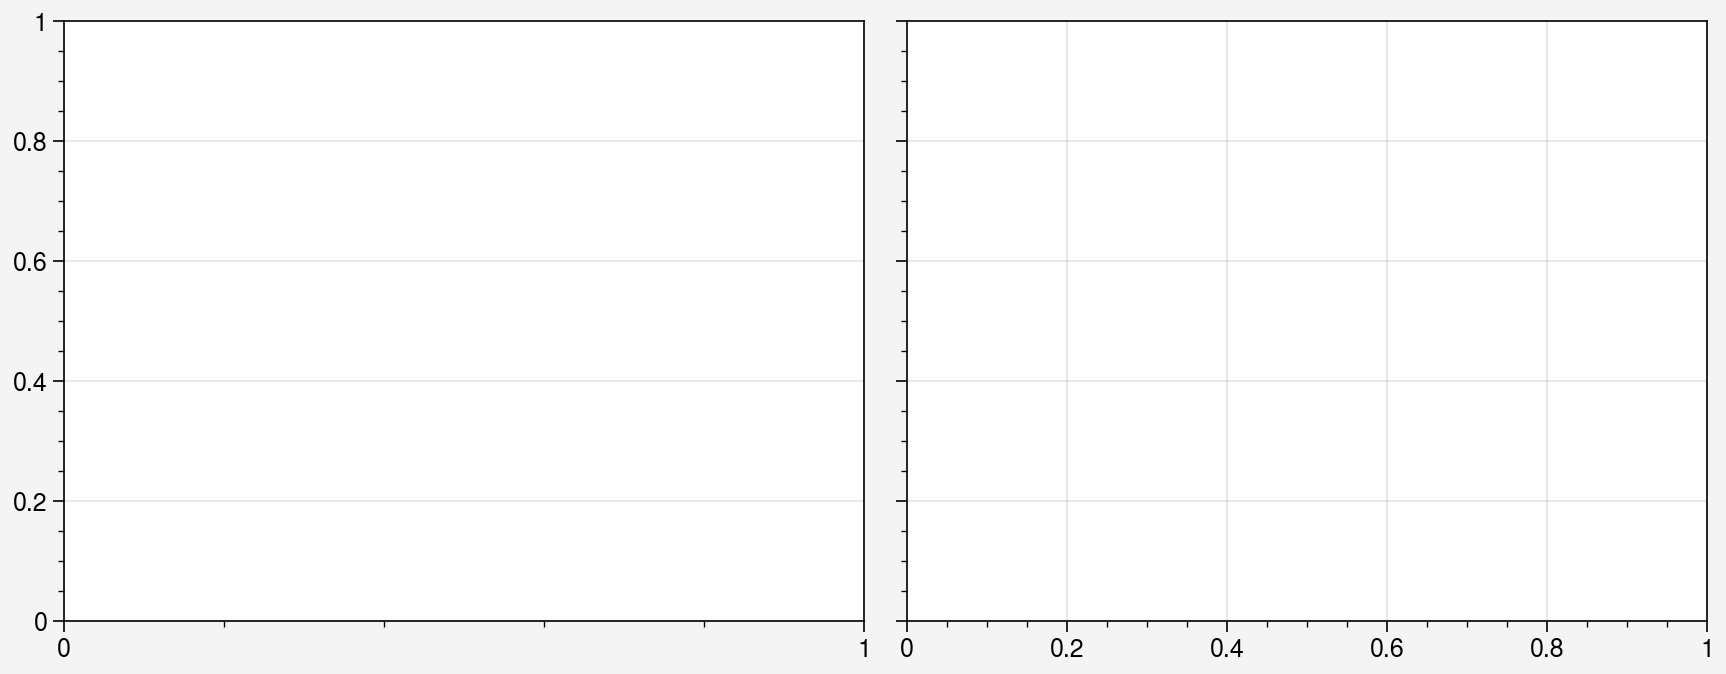

In [35]:
heatmapdf = metricsdf[['MSE','RMSE','MAE','R2']].copy()
for col in ['MSE','RMSE','MAE']:
    heatmapdf[col] = 1-(heatmapdf[col]-heatmapdf[col].min())/(heatmapdf[col].max()-heatmapdf[col].min())
heatmapdf['R2'] = (heatmapdf['R2']-heatmapdf['R2'].min())/(heatmapdf['R2'].max()-heatmapdf['R2'].min())


fig,axs = pplt.subplots(nrows=1,ncols=2,refwidth=4,refheight=3)
axs[0].format(
    
    # title='Normalized Performance Heatmap\n(Green = Better)',
    xticks=range(len(heatmapdf.columns)),xticklabels=heatmapdf.columns,yticks=range(len(heatmapdf.index)),yticklabels=heatmapdf.index)

im = axs[0].imshow(heatmapdf.values,aspect='auto',cmap='RdYlGn')

for i in range(len(heatmapdf.index)):
    for j in range(len(heatmapdf.columns)):
        axs[0].text(j,i,f'{heatmapdf.iloc[i,j]:.2f}',ha='center',va='center')

# # Table view
# axs[1].axis('off')
# table_data = metricsdf[['Title', 'MSE', 'RMSE', 'MAE', 'R2']].round(3)
# table = axs[1].table(cellText=table_data.values, colLabels=table_data.columns,
#                     cellLoc='center', loc='center')
# table.auto_set_font_size(False)
# table.set_fontsize(8)
# table.scale(1, 1.5)
# axs[1].format(title='Metrics Summary Table')

pplt.show()

In [ ]:
fig, axs = pplt.subplots(nrows=1, ncols=1, refwidth=6, refheight=4)

# Prepare data for line plot
models = metricsdf['Title'].values
metrics_to_plot = ['MSE', 'RMSE', 'MAE', 'R2']

# Normalize metrics to 0-1 for comparison on same plot
normalized_metrics = {}
for metric in metrics_to_plot:
    if metric == 'R2':
        # For R2, higher is better, so keep as is (assuming 0-1 range)
        normalized_metrics[metric] = metricsdf[metric].values
    else:
        # For MSE, RMSE, MAE, lower is better, so invert and normalize
        values = metricsdf[metric].values
        normalized_metrics[metric] = 1 - (values - values.min()) / (values.max() - values.min())

# Plot lines
colors = ['red', 'blue', 'green', 'orange']
for i, metric in enumerate(metrics_to_plot):
    axs.plot(range(len(models)), normalized_metrics[metric], 
             marker='o', label=metric, color=colors[i], linewidth=2)

axs.format(xlabel='Models', ylabel='Normalized Performance (Higher = Better)',
           title='Multi-Metric Model Comparison')
axs.set_xticks(range(len(models)))
axs.set_xticklabels(models, rotation=45)
axs.legend(loc='ur')
axs.grid(True, alpha=0.3)

pplt.show()

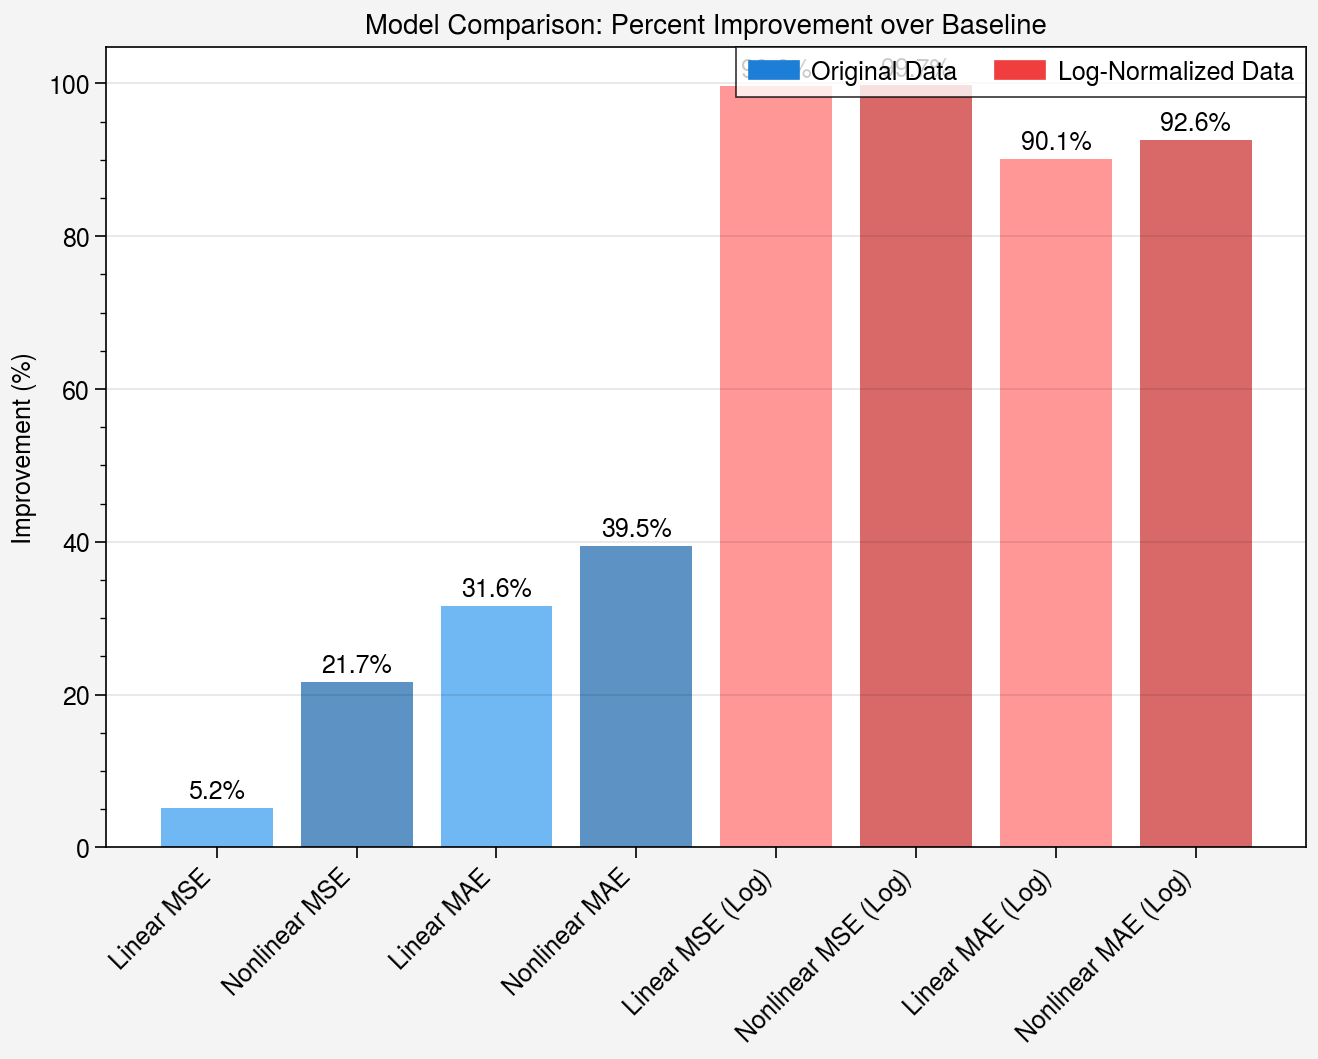


IMPROVEMENT SUMMARY:
Linear MSE               :    5.2% improvement
Nonlinear MSE            :   21.7% improvement
Linear MAE               :   31.6% improvement
Nonlinear MAE            :   39.5% improvement
Linear MSE (Log)         :   99.6% improvement
Nonlinear MSE (Log)      :   99.7% improvement
Linear MAE (Log)         :   90.1% improvement
Nonlinear MAE (Log)      :   92.6% improvement


In [36]:
baselinemse = np.mean((ytest['pr'].values - np.mean(ytrain['pr'].values))**2)
baselinemae = np.mean(np.abs(ytest['pr'].values - np.mean(ytrain['pr'].values)))

improvements = {}

# Process original models
for modelname, result in results.items():
    if 'mse' in modelname:
        baseline = baselinemse
    else:
        baseline = baselinemae
    improvement = (baseline - result['testloss']) / baseline * 100
    improvements[modelname] = improvement

# Process log-normalized models
for modelname, result in resultslog.items():
    if 'mse' in modelname:
        baseline = baselinemse
    else:
        baseline = baselinemae
    improvement = (baseline - result['testloss']) / baseline * 100
    improvements[modelname] = improvement

# Define all 8 models and their display names
models = ['linear_mse', 'relu_mse', 'linear_mae', 'relu_mae',
          'linear_mse_log', 'relu_mse_log', 'linear_mae_log', 'relu_mae_log']

model_labels = ['Linear MSE', 'Nonlinear MSE', 'Linear MAE', 'Nonlinear MAE',
                'Linear MSE (Log)', 'Nonlinear MSE (Log)', 'Linear MAE (Log)', 'Nonlinear MAE (Log)']

improvvalues = [improvements[model] for model in models]

# Color scheme: blue for original, red for log-normalized, light/dark for linear/nonlinear
colors = ['blue5', 'blue9', 'blue5', 'blue9',
          'red5', 'red9', 'red5', 'red9']

fig, ax = pplt.subplots(nrows=1, ncols=1, refwidth=6, refheight=4)
ax.format(title='Model Comparison: Percent Improvement over Baseline',
          xgrid=False, xticks=range(len(models)),
          xticklabels=model_labels, xminorticks='none',
          ylabel='Improvement (%)', ygrid=True, xrotation=45)

bars = ax.bar(range(len(models)), improvvalues, color=colors, alpha=0.7)

# Add percentage labels on bars
for i, (bar, improv) in enumerate(zip(bars, improvvalues)):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
            f'{improv:.1f}%', ha='center', va='bottom', fontsize=9)

# Add a legend to distinguish original vs log-normalized
import matplotlib.patches as mpatches
original_patch = mpatches.Patch(color='blue7', label='Original Data')
lognorm_patch = mpatches.Patch(color='red7', label='Log-Normalized Data')
ax.legend(handles=[original_patch, lognorm_patch], loc='ur')

pplt.show()

# Print summary
print("\nIMPROVEMENT SUMMARY:")
print("=" * 60)
for model, label, improv in zip(models, model_labels, improvvalues):
    print(f"{label:25s}: {improv:6.1f}% improvement")

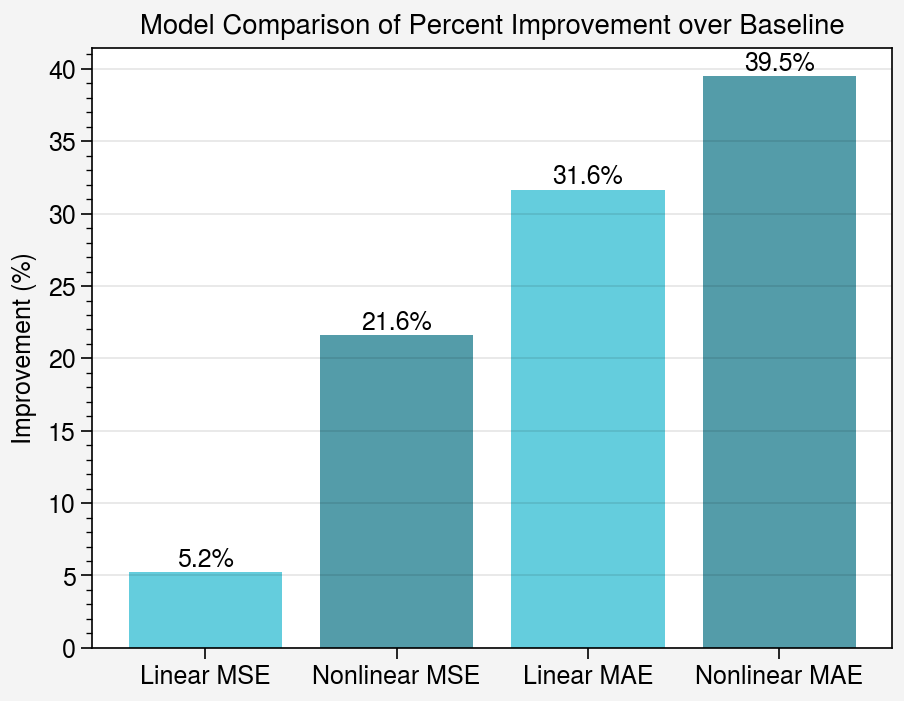

In [74]:
baselinemse = np.mean((ytest['pr'].values-np.mean(ytrain['pr'].values))**2)
baselinemae = np.mean(np.abs(ytest['pr'].values-np.mean(ytrain['pr'].values)))

improvements = {}
for modelname,result in results.items():
    if 'mse' in modelname:
        baseline = baselinemse
    else:
        baseline = baselinemae
    improvement = (baseline-result['testloss'])/baseline*100
    improvements[modelname] = improvement

models       = ['linear_mse','relu_mse','linear_mae','relu_mae']
improvvalues = [improvements[model] for model in models]
colors       = ['cyan5','cyan9','cyan5','cyan9']

fig,ax = pplt.subplots(nrows=1,ncols=1,refwidth=4,refheight=3)
ax.format(title='Model Comparison of Percent Improvement over Baseline',xgrid=False,xticks=range(len(models)),
          xticklabels=['Linear MSE','Nonlinear MSE','Linear MAE','Nonlinear MAE'],xminorticks='none',
          ylabel='Improvement (%)',ygrid=True)
bars = ax.bar(range(len(models)),improvvalues,color=colors,alpha=0.7)
for i,(bar,improv) in enumerate(zip(bars,improvvalues)):
    ax.text(bar.get_x()+bar.get_width()/2,bar.get_height(),f'{improv:.1f}%',ha='center',va='bottom')
pplt.show()

In [13]:
baseline = BASELINE(
    binwidth=0.002,
    binmin=-0.6,
    binmax=0.1,
    samplethresh=50,
    criterion=torch.nn.MSELoss())

baselinemodel   = baseline.fit(xtrain['bl'].values,ytrain['pr'].values)
baselineoutputs = baseline.predict(xtest['bl'].values)
baselineloss    = baseline.evaluate(xtest['bl'].values,ytest['pr'].values)

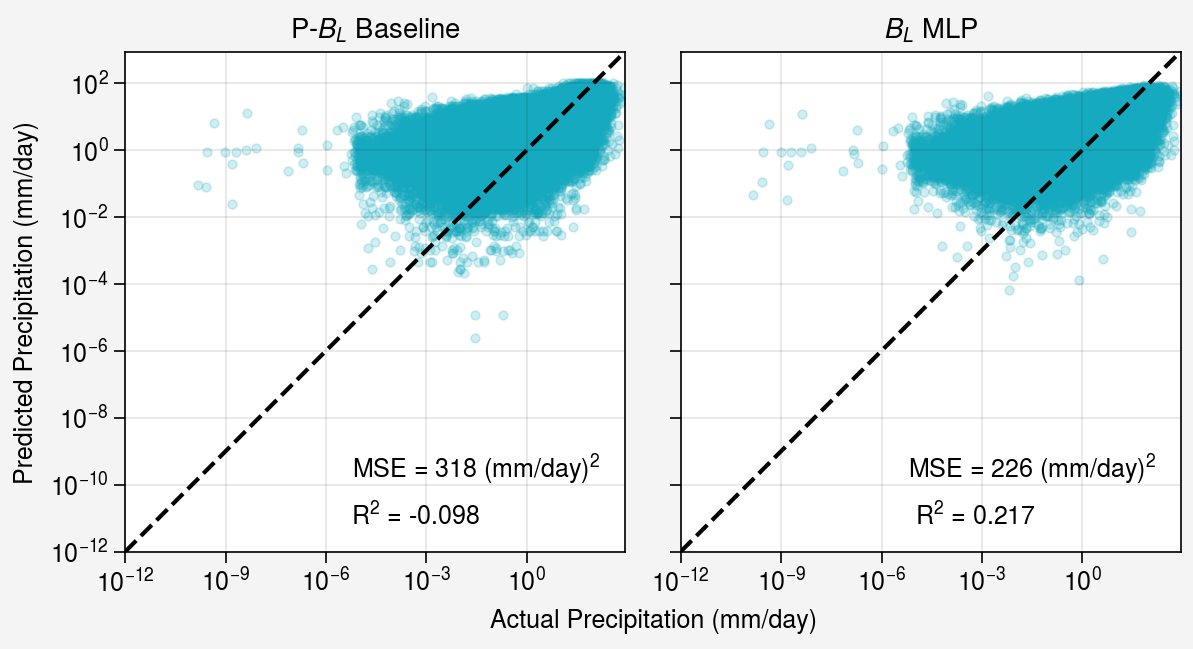

In [49]:
def r2_from_mse(mse,targets):
    ssres = mse*len(targets)
    sstot = np.sum((targets-np.mean(targets))**2)
    r2 = 1-(ssres/sstot)
    return r2

fig,axs = pplt.subplots(nrows=1,ncols=2)
axs.format(xlabel='Actual Precipitation (mm/day)',xscale='log',xformatter='log',ylabel='Predicted Precipitation (mm/day)',yscale='log',yformatter='log')
axs[0].format(title='P-$\mathit{B_L}$ Baseline')
axs[1].format(title='$\mathit{B_L}$ MLP')
axmin = max(1e-12,min(ytest['pr'].min(),baselineoutputs.min(),mlpoutputs.min()))
axmax = max(ytest['pr'].max(),baselineoutputs.max(),mlpoutputs.max())
for ax,outputs,mse in zip(axs,[baselineoutputs,mlpoutputs],[baselineloss,mlploss]):
    targets = ytest['pr'].values
    r2 = r2_from_mse(mse,targets)
    ax.scatter(targets,outputs,color='cyan6',markersize=10,alpha=0.2)
    line = np.logspace(np.log10(axmin),np.log10(axmax),num=100)
    ax.plot(line,line,'k--',linewidth=1.5)  
    ax.format(xlim=(axmin,axmax),ylim=(axmin,axmax))
    ax.text(0.95,0.2,f'MSE = {mse:.0f} (mm/day)$^2$',transform=ax.transAxes,va='top',ha='right')
    ax.text(0.71,0.1,f'R$^2$ = {r2:.3f}',transform=ax.transAxes,va='top',ha='right')
pplt.show()

In [127]:
def custom_loss_functions():
    
    def mse_loss(ytrue,ypred):
        return np.mean((ytrue-ypred)**2)
    
    def mae_loss(ytrue,ypred):
        return np.mean(np.abs(ytrue-ypred))
    
    def rmse_loss(ytrue,ypred):
        return np.sqrt(np.mean((ytrue-ypred)**2))
    
    def huber_loss(ytrue,ypred,delta=1.0):
        residual = np.abs(ytrue-ypred)
        return np.mean(np.where(residual<=delta,0.5*residual**2, delta*(residual-0.5*delta)))
    
    def log_cosh_loss(ytrue,ypred):
        return np.mean(np.log(np.cosh(ypred-ytrue)))
    
    def quantile_loss(ytrue,ypred,quantile=0.5):
        residual = ytrue-ypred
        return np.mean(np.maximum(quantile*residual,(quantile-1)*residual))
    
    return {
        'MSE':mse_loss,
        'MAE':mae_loss, 
        'RMSE':rmse_loss,
        'Huber':huber_loss,
        'LogCosh':log_cosh_loss,
        'Quantile_50':lambda ytrue,ypred:quantile_loss(ytrue,ypred,0.5),
        'Quantile_90':lambda ytrue,ypred:quantile_loss(ytrue,ypred,0.9)}